In [4]:
import pandas as pd
import importlib
import os
import random
from tqdm import tqdm
import numpy as np

import src_dataloader.supernova_dataset as SupernovaDataset

import src_dataloader.alert_processor as AlertProcessor
import src_dataloader.data_preprocessor as DataPreprocessor
import src_dataloader.photometry_processor as PhotometryProcessor
import src_dataloader.gaussian_process as GaussianProcess
import src_dataloader.tools as tools
import src_dataloader.data_generator as DataGenerator
import src_dataloader.plot_data as plot_data
import src_dataloader.predictions as predi

importlib.reload(SupernovaDataset)
importlib.reload(AlertProcessor)
importlib.reload(DataPreprocessor)
importlib.reload(PhotometryProcessor)
importlib.reload(GaussianProcess)
importlib.reload(tools)
importlib.reload(DataGenerator)
importlib.reload(predi)
importlib.reload(plot_data)

<module 'src_dataloader.plot_data' from '/data/dev/ml_skyportal/src_dataloader/plot_data.py'>

In [5]:
BTS_PATH = 'BTS_categorized.csv'
KOWALSKI_PATH = 'data_kowalski'
DATA_PATH = 'data_train'
KERNEL_PATH = 'kernel.pkl'

In [3]:
df_bts = pd.read_csv(BTS_PATH)

labels_step1 = ['Other', 'SN']
labels_step2 = ['SN I', 'SN II', 'Other']
labels_step3a = ['SN Ia', 'SN Ib/c', 'Other']
labels_step3b = ['SN II', 'SN IIn/b', 'Other']

df_bts['type_step1'] = df_bts['type_step1'].apply(lambda x: labels_step1.index(x))
df_bts['type_step2'] = df_bts['type_step2'].apply(lambda x: labels_step2.index(x))
df_bts['type_step3a'] = df_bts['type_step3a'].apply(lambda x: labels_step3a.index(x))
df_bts['type_step3b'] = df_bts['type_step3b'].apply(lambda x: labels_step3b.index(x))

tools.print_types(df_bts)

type_step1
1    8688
0    5465
Name: count, dtype: int64
type_step2
0    6831
2    5575
1    1747
Name: count, dtype: int64
type_step3a
2    7322
0    6371
1     460
Name: count, dtype: int64
type_step3b
2    12406
0     1392
1      355
Name: count, dtype: int64


In [6]:
files = os.listdir('data_train')

obj_ids = set()
for file in files:
    obj_id = file.split('_')[0]
    obj_ids.add(obj_id)

len(obj_ids)

2014

In [7]:
files = os.listdir('data_train')

# load the list of objects
import pickle
with open('obj_ids_test.pkl', 'rb') as f:
    obj_ids = pickle.load(f)

obj_ids_train = set()
for file in files:
    obj_id = file.split('_')[0]
    obj_ids_train.add(obj_id)

print(len(obj_ids_train))
#obj_ids = set(obj_ids) - set(obj_ids_train)
print(len(obj_ids))

2014
480


In [8]:
def get_data(df, n=20):
    step_3a_df = df[df['type_step3a'] == 0]
    step_3a_df = step_3a_df.sample(n=n, random_state=42)

    step_3ab_df = df[df['type_step3a'] == 1]
    step_3ab_df = step_3ab_df.sample(n=n, random_state=42)

    step_3b_df = df[df['type_step3b'] == 0]
    step_3b_df = step_3b_df.sample(n=n, random_state=42)

    step_3bb_df = df[df['type_step3b'] == 1]
    step_3bb_df = step_3bb_df.sample(n=n, random_state=42)

    other_df = df[df['type_step1'] == 0]
    other_df = other_df.sample(n=n*7)

    res_df = pd.concat([step_3a_df, other_df, step_3ab_df, step_3b_df, step_3bb_df])
    return res_df

In [9]:
obj_ids = ['ZTF19aadgimr']

In [10]:
df = df_bts[df_bts['obj_id'].isin(obj_ids_train)]
df = df.reset_index(drop=True)
tools.print_types(df)

type_step1
0    1044
1     970
Name: count, dtype: int64
type_step2
2    1044
1     498
0     472
Name: count, dtype: int64
type_step3a
2    1542
0     243
1     229
Name: count, dtype: int64
type_step3b
2    1516
0     251
1     247
Name: count, dtype: int64


In [11]:
res_df = get_data(df, n=40)
tools.print_types(res_df)
print(len(res_df))

type_step1
0    280
1    160
Name: count, dtype: int64
type_step2
2    280
0     80
1     80
Name: count, dtype: int64
type_step3a
2    360
0     40
1     40
Name: count, dtype: int64
type_step3b
2    360
0     40
1     40
Name: count, dtype: int64
440


In [12]:
dataset = SupernovaDataset.SupernovaDataset(DATA_PATH, base_path=KOWALSKI_PATH, kernel_path=KERNEL_PATH, is_i_filter=True)

In [175]:
dataset.preprocess_data(res_df, KOWALSKI_PATH, is_prediction=False)
len(dataset)

Loading data: 100%|██████████| 440/440 [01:13<00:00,  6.01it/s]


9104

In [11]:
dataset.preprocess_and_save()

NameError: name 'dataset' is not defined

In [49]:
len(dataset)

7234

# Train

In [6]:
step = 'type_step1'

data_df = tools.create_df_from_file(BTS_PATH, 'data_train')
tools.print_types(data_df, columns=[step])

type_step1
SN       23968
Other    19294
Name: count, dtype: int64


In [7]:
if step != 'type_step1':
    data_df = data_df[data_df[step] != 'Other']
    data_df = data_df.reset_index(drop=True)
    tools.print_types(data_df, columns=[step])

In [8]:
data_df[step].unique()

array(['SN', 'Other'], dtype=object)

In [9]:
def plot_df(data_df, nb_max=10):
    data_df = data_df.sort_values('file')
    data_df = data_df.drop_duplicates(subset='name', keep='last')
    data_df = data_df.sample(frac=1).reset_index(drop=True)

    nb = len(data_df)
    if nb_max < nb:
        nb = nb_max

    for i in range(nb):
        obj_id = data_df.iloc[i]['name']
        alerte = int(data_df.iloc[i]['file'].split('_')[-1].split('.')[0])
        type_obj = data_df.iloc[i][step]
        plot_data.plot_photometry(obj_id, alerte=None, type_obj=type_obj)

In [17]:
plot_df(data_df, 10)

/data/dev/ml_skyportal/src_dataloader/plot_data.py:196: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/data/dev/ml_skyportal/src_dataloader/plot_data.py:196: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/data/dev/ml_skyportal/src_dataloader/plot_data.py:196: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
train_files, val_files, class_weights = tools.split_and_compute_class_weights(data_df, step, nb=10000, verbose=True)
print(class_weights)

type_step1
SN       7988
Other    7900
Name: count, dtype: int64
type_step1
Other    2100
SN       2012
Name: count, dtype: int64
{0: 1.0055696202531645, 1: 0.9944917376064096}


In [11]:
batch_size = 32

DATA_PATH = 'data_train'

train_generator = DataGenerator.DataGenerator(DATA_PATH, step=step, batch_size=batch_size, shuffle=True, file_list=train_files)
val_generator = DataGenerator.DataGenerator(DATA_PATH, step=step, batch_size=batch_size, shuffle=True, file_list=val_files)

In [12]:
sample = train_generator.__getitem__(0)

2024-08-01 13:27:58.455350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-01 13:27:58.487244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-01 13:27:58.487458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
import tensorflow as tf


def custom_loss(y_true, y_pred):
    try:
        base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1 - tf.round(y_pred)), tf.float32))
        false_negative_penalty = 0.6
        penalized_loss = base_loss + false_negative_penalty * false_negatives
        return penalized_loss
    except Exception as e:
        print("Error in custom_loss:", e)
        raise e

In [14]:
import tensorflow as tf
import src_dataloader.model as model
importlib.reload(model)

sample, target = train_generator.__getitem__(0)

input_shapes = [sample[0].shape[1:], sample[1].shape[1:], sample[2].shape[1:]]

num_filters = 64
num_classes = target.shape
num_layers = 1
d_model = 64
num_heads = 8
dff = 128
rate = 0.1

T2model = model.T2Model(num_filters=num_filters, num_classes=num_classes, num_layers=num_layers,
                d_model=d_model, num_heads=num_heads, dff=dff, input_shapes=input_shapes, 
                rate=rate)

T2model.build(input_shapes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

T2model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

T2model.summary()

Model: "t2_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_masking_layer            │ (None, None, 4)        │             0 │
│ (CustomMaskingLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_embedding (ConvEmbedding)  │ (None, None, 64)       │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, None, 64)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, None, 64)       │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_processor                 │ (None, 3136)           │       181,792 │
│ (ImageProcessor)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ metadata_processor              │ (None, 128)            │        17,960 │
│ (MetadataProcessor)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multimodal_model                │ (None, 1)              │       225,881 │
│ (MultimodalModel)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_1 (Concatenate)     │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,003 (1.75 MB)

 Trainable params: 459,963 (1.75 MB)

 Non-trainable params: 40 (160.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

DIR_CHECKPOINTS = 'checkpoints/'

checkpoint_path = DIR_CHECKPOINTS + 'step1_V1.weights.h5'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

callbacks = [checkpoint_callback, early_stopping_callback]

In [16]:
T2model.load_weights('checkpoints/step1_V3.weights.h5')

/data/dev/ml_skyportal/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 



In [24]:
history = T2model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks)

Epoch 1/10


/data/dev/ml_skyportal/env/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
I0000 00:00:1722534432.415421 2511275 service.cc:145] XLA service 0x7f449c002ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722534432.415448 2511275 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-08-01 10:47:12.548252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 10:47:12.821824: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024

  2/497 ━━━━━━━━━━━━━━━━━━━━ 1:09 140ms/step - accuracy: 0.6172 - loss: 0.6473 

I0000 00:00:1722534442.411852 2511275 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 30/497 ━━━━━━━━━━━━━━━━━━━━ 1:00 130ms/step - accuracy: 0.5675 - loss: 0.6861

2024-08-01 10:47:26.485928: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-08-01 10:47:26.583330: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5948 - loss: 0.6767
Epoch 1: val_loss improved from inf to 0.63172, saving model to checkpoints/step1_V1.weights.h5
497/497 ━━━━━━━━━━━━━━━━━━━━ 104s 181ms/step - accuracy: 0.5949 - loss: 0.6767 - val_accuracy: 0.6381 - val_loss: 0.6317
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6639 - loss: 0.6145
Epoch 2: val_loss improved from 0.63172 to 0.59491, saving model to checkpoints/step1_V1.weights.h5
497/497 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.6640 - loss: 0.6145 - val_accuracy: 0.6880 - val_loss: 0.5949
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6890 - loss: 0.5850
Epoch 3: val_loss improved from 0.59491 to 0.58863, saving model to checkpoints/step1_V1.weights.h5
497/497 ━━━━━━━━━━━━━━━━━━━━ 79s 157ms/step - accuracy: 0.6890 - loss: 0.5850 - val_accuracy: 0.6960 - val_loss: 0.5886
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7030 - loss: 0.5662
Ep

In [25]:
plot_data.plot_history(history)

In [77]:
test_files = os.listdir('data_try')
test_generator = DataGenerator.DataGenerator('data_try', step=step, batch_size=batch_size, shuffle=False, file_list=test_files)

In [78]:
T2model.load_weights(checkpoint_path)

In [79]:
T2model.load_weights(checkpoint_path)

test_loss, test_accuracy = T2model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

601/601 ━━━━━━━━━━━━━━━━━━━━ 68s 113ms/step - accuracy: 0.6858 - loss: 2.5860
Test loss: 2.6239476203918457
Test accuracy: 0.6871258020401001


In [80]:
from sklearn.metrics import classification_report
from tqdm import tqdm

y_pred = T2model.predict(test_generator)

y_true = []
for _, labels in tqdm(test_generator):
    if len(labels) > 0:
        y_true.extend(labels.numpy())
    else:
        break

y_true = y_true[:len(y_pred)]
y_pred_max = (y_pred >= 0.5).astype(int)

601/601 ━━━━━━━━━━━━━━━━━━━━ 71s 116ms/step


100%|██████████| 601/601 [00:57<00:00, 10.40it/s]


In [81]:
report = classification_report(y_true, y_pred_max)
print(report)

              precision    recall  f1-score   support

           0       0.56      0.38      0.45      6511
           1       0.73      0.85      0.78     12698

    accuracy                           0.69     19209
   macro avg       0.64      0.61      0.62     19209
weighted avg       0.67      0.69      0.67     19209



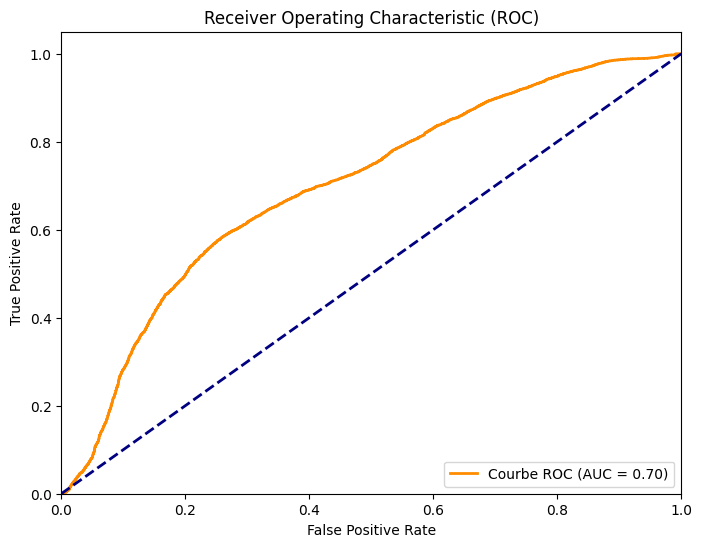

In [82]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

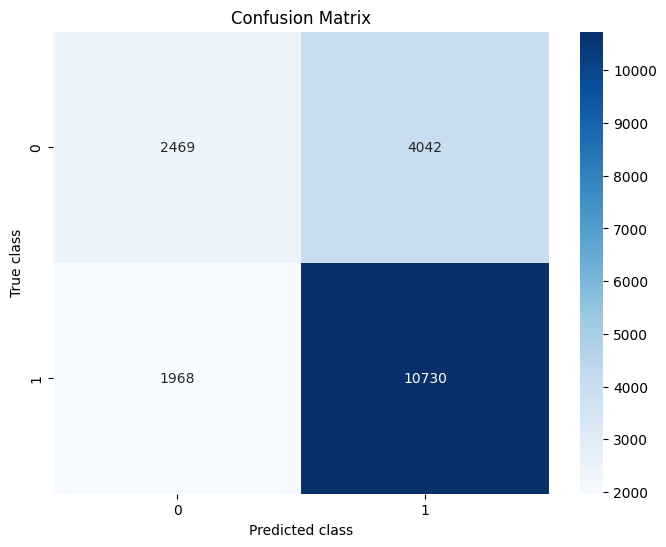

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_max)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# en anglais
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix')
plt.show()

# Prediction

In [15]:
def supernova_classification(test_data_dir, step, num_predictions=None, shuffle=True, verbose=True):
    types_dict = {
        'type_step1': ['Other', 'SN'],
        'type_step2': ['SN I', 'SN II'],
        'type_step3a': ['SN Ia', 'SN Ib/c'],
        'type_step3b': ['SN II', 'SN IIn/b']
    }

    weight_files = {
        'type_step1': 'checkpoints/step1_V1.weights.h5',
        'type_step2': 'checkpoints/step2_V1.weights.h5',
        'type_step3a': 'checkpoints/step3a_V1.weights.h5',
        'type_step3b': 'checkpoints/step3b_V1.weights.h5'
    }

    model = T2model#predi.define_model()
        
    model.load_weights(weight_files[step])  
      
    obj_id_to_files = predi.group_files_by_obj_id(test_data_dir)

    if step != 'type_step1':
        df_bts_other = pd.read_csv(BTS_PATH)
        df_bts_other = df_bts_other[df_bts_other[step] != 'Other']
        obj_ids = df_bts_other['obj_id'].values
        obj_id_to_files = {obj_id: files for obj_id, files in obj_id_to_files.items() if obj_id in obj_ids}

    if shuffle:
        obj_id_list = list(obj_id_to_files.keys())
        random.shuffle(obj_id_list)
        obj_id_to_files = {obj_id: obj_id_to_files[obj_id] for obj_id in obj_id_list}
    
    all_results = []
    summary_results = []
    types = types_dict[step]
    
    obj_id_list = list(obj_id_to_files.keys())
    if num_predictions is not None:
        obj_id_list = obj_id_list[:num_predictions]

    for obj_id in tqdm(obj_id_list, desc='Obj ID', unit='obj_id'):
        files = obj_id_to_files[obj_id]
        obj_results = []

        photo_df, metadata, _ = PhotometryProcessor.PhotometryProcessor.process_csv(obj_id, df_bts, 'data_kowalski'), *AlertProcessor.AlertProcessor.get_process_alerts(obj_id, 'data_kowalski')
        photo_df, metadata = photo_df.sort_values(by='jd'), metadata.sort_values(by='jd')
        
        metadata['mjd'] = metadata['jd'] - 2400000.5
        metadata = tools.Normalize_mjd(metadata)
        metadata = metadata[metadata['mjd'] < 200]

        data_predictions = DataGenerator.DataGenerator(test_data_dir, step=step, batch_size=len(files), shuffle=False, file_list=files)
        

        data, target = data_predictions.__getitem__(0)

        predictions = model.predict(data_predictions, verbose=0)

        for i in range(len(predictions)):
            file = files[i]
            alert_num = int(file.split('_')[-1].split('.')[0])
            obj_results.append({
                'obj_id': obj_id,
                'alert_num': i,
                'mjd': metadata.iloc[alert_num]['mjd'],
                'prediction': predictions[i][0],
                'class_prediction': (predictions[i][0] > 0.5).astype(int),
                'ground_truth': target.numpy()[0]
            })
        
        final_prediction = np.mean([pred['prediction'] for pred in obj_results])
        final_class = (final_prediction > 0.5).astype(int)
        confidence = final_prediction if final_class == 1 else 1 - final_prediction
        ground_truth = obj_results[0]['ground_truth']

        if verbose:
            print(f"Obj ID: {obj_id}")
            print(f"Ground Truth: {types[ground_truth]}")
            print(f"Final Prediction: {types[final_class]}")
            print(f"Confidence: {confidence*100:.2f}%")

        summary_results.append({
            'obj_id': obj_id,
            'ground_truth': types[ground_truth],
            'final_prediction': types[final_class],
            'confidence': confidence * 100
        })
        
        df_obj = pd.DataFrame(obj_results)
        all_results.extend(obj_results)

        if verbose:
            predi.plot_interactive_supernova_classification(df_obj, types)
            predi.plot_interactive_supernova_classification_mjd(df_obj, types)

            max_alert_num = max([res['alert_num'] for res in obj_results])
            plot_data.plot_photometry(obj_id, alerte=None, type_obj=types[ground_truth])

    df_all_results = pd.DataFrame(all_results)
    df_summary_results = pd.DataFrame(summary_results)
    
    return df_all_results, df_summary_results

In [19]:
df_results, df_summary = supernova_classification('data_try', 'type_step1', num_predictions=10, shuffle=True, verbose=True)

/data/dev/ml_skyportal/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 

Obj ID:   0%|          | 0/10 [00:00<?, ?obj_id/s]

Obj ID: ZTF24aaejjmk
Ground Truth: Other
Final Prediction: Other
Confidence: 58.74%


Obj ID:  10%|█         | 1/10 [00:00<00:02,  3.83obj_id/s]

Obj ID: ZTF20aattoch
Ground Truth: SN
Final Prediction: SN
Confidence: 78.07%


Obj ID:  20%|██        | 2/10 [00:03<00:15,  1.90s/obj_id]

Obj ID: ZTF20abrnvnn
Ground Truth: SN
Final Prediction: Other
Confidence: 53.82%


/data/dev/ml_skyportal/src_dataloader/plot_data.py:196: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Obj ID:  30%|███       | 3/10 [00:04<00:11,  1.60s/obj_id]

Obj ID: ZTF22abxweov
Ground Truth: Other
Final Prediction: Other
Confidence: 57.84%


Obj ID:  40%|████      | 4/10 [00:05<00:09,  1.51s/obj_id]

Obj ID: ZTF23aafvwow
Ground Truth: Other
Final Prediction: Other
Confidence: 70.03%


Obj ID:  50%|█████     | 5/10 [00:06<00:05,  1.07s/obj_id]

Obj ID: ZTF22aaodelu
Ground Truth: Other
Final Prediction: Other
Confidence: 68.61%


/data/dev/ml_skyportal/src_dataloader/plot_data.py:196: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Obj ID:  60%|██████    | 6/10 [00:06<00:03,  1.21obj_id/s]

Obj ID: ZTF20abixkhh
Ground Truth: SN
Final Prediction: SN
Confidence: 63.26%


Obj ID:  70%|███████   | 7/10 [00:09<00:04,  1.66s/obj_id]

Obj ID: ZTF20acqwaiy
Ground Truth: Other
Final Prediction: Other
Confidence: 63.58%


Obj ID:  80%|████████  | 8/10 [00:10<00:02,  1.23s/obj_id]

Obj ID: ZTF21aabqtsd
Ground Truth: SN
Final Prediction: Other
Confidence: 56.60%


Obj ID:  90%|█████████ | 9/10 [00:10<00:00,  1.09obj_id/s]

Obj ID: ZTF20achmgee
Ground Truth: SN
Final Prediction: SN
Confidence: 68.07%


Obj ID: 100%|██████████| 10/10 [00:12<00:00,  1.27s/obj_id]


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def raw_average(df):
    final_predictions = df.groupby('obj_id', as_index=False)['prediction'].mean().rename(columns={'prediction': 'final_prediction'})
    final_predictions = final_predictions.merge(df[['obj_id', 'ground_truth']].drop_duplicates(), on='obj_id')
    final_predictions['success'] = (final_predictions['final_prediction'].round() == final_predictions['ground_truth']).astype(int)
    return final_predictions

def weighted_average(df):
    df['weights'] = df['alert_num']
    weighted_sum = df.groupby('obj_id').apply(lambda x: np.sum(x['prediction'] * x['weights']), include_groups=False)
    weight_sum = df.groupby('obj_id')['weights'].sum()

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        final_prediction_values = np.where(weight_sum.values != 0, weighted_sum.values / weight_sum.values, 0)

    final_prediction = pd.DataFrame({
        'obj_id': weighted_sum.index,
        'final_prediction': final_prediction_values
    })

    final_prediction = final_prediction.merge(df[['obj_id', 'ground_truth']].drop_duplicates(), on='obj_id')
    final_prediction['success'] = (final_prediction['final_prediction'].round() == final_prediction['ground_truth']).astype(int)
    
    final_prediction = final_prediction.dropna()
    final_prediction = final_prediction.reset_index(drop=True)
    return final_prediction

def last_alert(df):
    last_alert = df.sort_values('alert_num').drop_duplicates('obj_id', keep='last')
    final_prediction = last_alert[['obj_id', 'prediction', 'ground_truth']].rename(columns={'prediction': 'final_prediction'}).reset_index(drop=True)
    final_prediction['success'] = (final_prediction['final_prediction'].round() == final_prediction['ground_truth']).astype(int)
    return final_prediction

def exponential_smoothing(df, alpha=0.3):
    def smooth(group):
        smoothed_prediction = group.iloc[0]
        for i in range(1, len(group)):
            smoothed_prediction = alpha * group.iloc[i] + (1 - alpha) * smoothed_prediction
        return smoothed_prediction
    
    df['smoothed_prediction'] = df.groupby('obj_id')['prediction'].transform(lambda x: smooth(x))
    df['final_prediction'] = df.groupby('obj_id')['smoothed_prediction'].transform('last')
    final_predictions = df[['obj_id', 'final_prediction', 'ground_truth']].drop_duplicates(subset=['obj_id'])
    final_predictions['success'] = (final_predictions['final_prediction'].round() == final_predictions['ground_truth']).astype(int)
    return final_predictions

def calculate_success_percentage(df, prediction_function):
    final_predictions = prediction_function(df)
    success_percentage = (final_predictions['success'].sum() / final_predictions.shape[0]) * 100
    return success_percentage

def success_by_alert_count(df, prediction_function):
    max_alerts = df['alert_num'].max()
    success_by_alert_count = []

    for alert_count in range(1, max_alerts + 1):
        df_subset = df.groupby('obj_id').filter(lambda x: len(x) >= alert_count)
        df_subset = df_subset[df_subset['alert_num'] < alert_count]
        final_predictions = prediction_function(df_subset)
        success_percentage = (final_predictions['success'].sum() / final_predictions.shape[0]) * 100 if final_predictions.shape[0] > 0 else 0
        num_objects = final_predictions.shape[0]
        success_by_alert_count.append({
            'alert_count': alert_count,
            'success': success_percentage,
            'num_objects': num_objects
        })

    return pd.DataFrame(success_by_alert_count)

def plot_success_by_alert_count(success_percentage_by_alert_count):
    success_percentage_by_alert_count = success_percentage_by_alert_count[success_percentage_by_alert_count['num_objects'] > 0]
    fig = px.line(success_percentage_by_alert_count, x='alert_count', y='success',
                  labels={'alert_count': 'Number of Predictions', 'success': 'Success Percentage'},
                  title='Success Percentage by Number of Predictions',
                  hover_data={'num_objects': True})
    fig.show()

In [35]:
list_function = [raw_average, weighted_average, last_alert, exponential_smoothing]

for function in list_function:
    success_percentage = calculate_success_percentage(df_results, function)
    print(f"Success Percentage ({function.__name__}):", success_percentage)

    success_percentage_by_alert_count = success_by_alert_count(df_results, function)
    plot_success_by_alert_count(success_percentage_by_alert_count)

Success Percentage (raw_average): 70.7808564231738


Success Percentage (weighted_average): 68.76574307304786


Success Percentage (last_alert): 62.21662468513854


Success Percentage (exponential_smoothing): 66.49874055415617


# Hyper Search

In [89]:
step = 'type_step1'

data_df = tools.create_df_from_file(BTS_PATH, 'data_test')
train_files, val_files, class_weights = tools.split_and_compute_class_weights(data_df, step, nb=2000, verbose=True)
print(class_weights)

type_step1
Other    1622
SN       1608
Name: count, dtype: int64
type_step1
SN       392
Other    378
Name: count, dtype: int64
{0: 0.9956843403205918, 1: 1.0043532338308458}


In [90]:
import wandb
wandb.login()

True

In [91]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'num_filters_d_model': {
            'values': [64, 128, 256]
        },
        'num_layers': {
            'values': [1, 2, 3]
        },
        'num_heads': {
            'values': [8, 16]
        },
        'dff': {
            'values': [128, 256, 512]
        },
        'rate': {
            'values': [0.2, 0.3, 0.4, 0.5]
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 1e-4,
            'max': 1e-3
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop', 'adamax']
        },
    }
}

In [92]:
sweep_id = wandb.sweep(sweep_config, project="ml_search")

Create sweep with ID: qyogeaoi
Sweep URL: https://wandb.ai/skyportal_ml/ml_search/sweeps/qyogeaoi


In [94]:
import src_dataloader.model as model

def build_model(config):
    return model.T2Model(num_filters=config.num_filters_d_model, 
                      num_classes=1, 
                      num_layers=config.num_layers,
                      d_model=config.num_filters_d_model, 
                      num_heads=config.num_heads, 
                      dff=config.dff, 
                      input_shapes=input_shapes, 
                      rate=config.rate)

def train():
    wandb.init(config=sweep_config)
    config = wandb.config

    step = 'type_step1'
    batch_size = config.batch_size

    train_generator = DataGenerator.DataGenerator(DATA_PATH, step=step, batch_size=batch_size, shuffle=True, file_list=train_files)
    val_generator = DataGenerator.DataGenerator(DATA_PATH, step=step, batch_size=batch_size, shuffle=True, file_list=val_files)

    sample, target = train_generator.__getitem__(0)

    input_shapes = [sample[0].shape[1:], sample[1].shape[1:], sample[2].shape[1:]]
    
    model = build_model(config)
    model.build(input_shapes)

    if config.optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    elif config.optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=config.learning_rate)
    elif config.optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=config.learning_rate)
    elif config.optimizer == 'adamax':
        opt = tf.keras.optimizers.Adamax(learning_rate=config.learning_rate)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

    model.compile(optimizer=opt, 
                  loss=custom_loss, 
                  metrics=['accuracy'])
    
    history = model.fit(train_generator, epochs=5, validation_data=val_generator)
    
    for epoch, (loss, val_loss, acc, val_acc) in enumerate(zip(history.history['loss'], 
                                                               history.history['val_loss'], 
                                                               history.history['accuracy'], 
                                                               history.history['val_accuracy'])):
        wandb.log({"epoch": epoch, "loss": loss, "val_loss": val_loss, "accuracy": acc, "val_accuracy": val_acc})
        print(f"Epoch {epoch+1}: Training Loss = {loss:.4f}, Validation Loss = {val_loss:.4f}, Training Accuracy = {acc:.4f}, Validation Accuracy = {val_acc:.4f}")


In [95]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: ycwdldlt with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	dff: 256
wandb: 	kernel_regularizer: None
wandb: 	learning_rate: 0.0009851397419455685
wandb: 	num_filters_d_model: 128
wandb: 	num_heads: 8
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	rate: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5


2024-07-24 18:30:10.986578: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:30:11.098143: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


12/26 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step - accuracy: 0.5452 - loss: 12.3158

2024-07-24 18:30:27.679724: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:30:27.765869: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 932ms/step - accuracy: 0.5718 - loss: 11.0811 - val_accuracy: 0.6636 - val_loss: 4.4805
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step - accuracy: 0.6601 - loss: 7.4173 - val_accuracy: 0.6961 - val_loss: 4.4589
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 0.7130 - loss: 6.1108 - val_accuracy: 0.6831 - val_loss: 1.9939
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step - accuracy: 0.7298 - loss: 5.7511 - val_accuracy: 0.6818 - val_loss: 1.6613
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.7421 - loss: 5.8239 - val_accuracy: 0.6883 - val_loss: 2.3858
Epoch 1: Training Loss = 9.4614, Validation Loss = 4.4805, Training Accuracy = 0.6077, Validation Accuracy = 0.6636
Epoch 2: Training Loss = 7.1547, Validation Loss = 4.4589, Training Accuracy = 0.6737, Validation Accuracy = 0.6961
Epoch 3: Training Loss = 6.0039, Validation Loss = 1.9939, Training Accuracy = 0.7142, Validation Accuracy = 0.6831
Epoch 4: Training Los

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9u9i8zd0 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	dff: 128
wandb: 	kernel_regularizer: l1
wandb: 	learning_rate: 0.0009856297238769495
wandb: 	num_filters_d_model: 64
wandb: 	num_heads: 8
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	rate: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5


2024-07-24 18:32:12.898957: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:32:13.077991: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5077 - loss: 11.2504

2024-07-24 18:32:36.629739: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:32:36.785355: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5121 - loss: 11.1096 - val_accuracy: 0.6870 - val_loss: 5.7555
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 582ms/step - accuracy: 0.6362 - loss: 8.4834 - val_accuracy: 0.5779 - val_loss: 1.1607
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 582ms/step - accuracy: 0.6979 - loss: 6.1233 - val_accuracy: 0.6442 - val_loss: 1.5436
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 585ms/step - accuracy: 0.7218 - loss: 6.2459 - val_accuracy: 0.6429 - val_loss: 1.3491
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 571ms/step - accuracy: 0.7219 - loss: 5.7701 - val_accuracy: 0.6714 - val_loss: 3.7329
Epoch 1: Training Loss = 9.9163, Validation Loss = 5.7555, Training Accuracy = 0.5502, Validation Accuracy = 0.6870
Epoch 2: Training Loss = 7.2919, Validation Loss = 1.1607, Training Accuracy = 0.6678, Validation Accuracy = 0.5779
Epoch 3: Training Loss = 6.1502, Validation Loss = 1.5436, Training Accuracy = 0.7050, Validation Accuracy = 0.6442
Epoch 4: Training Loss =

wandb: Agent Starting Run: lsvftvtw with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	dff: 128
wandb: 	kernel_regularizer: None
wandb: 	learning_rate: 0.0001595848529123358
wandb: 	num_filters_d_model: 64
wandb: 	num_heads: 8
wandb: 	num_layers: 2
wandb: 	optimizer: sgd
wandb: 	rate: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5


2024-07-24 18:34:25.461796: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:34:25.499409: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


 93/101 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.5007 - loss: 3.4971

2024-07-24 18:34:50.284173: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:34:50.314081: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 327ms/step - accuracy: 0.5010 - loss: 3.4972 - val_accuracy: 0.5104 - val_loss: 1.9421
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.5012 - loss: 3.6020 - val_accuracy: 0.5104 - val_loss: 1.9411
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.5070 - loss: 3.6483 - val_accuracy: 0.5091 - val_loss: 1.9400
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.4829 - loss: 3.5774 - val_accuracy: 0.5091 - val_loss: 1.9390
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.5073 - loss: 3.7384 - val_accuracy: 0.5104 - val_loss: 1.9379
Epoch 1: Training Loss = 3.4904, Validation Loss = 1.9421, Training Accuracy = 0.5037, Validation Accuracy = 0.5104
Epoch 2: Training Loss = 3.5096, Validation Loss = 1.9411, Training Accuracy = 0.4988, Validation Accuracy = 0.5104
Epoch 3: Training Loss = 3.6219, Validation Loss = 1.9400, Training Accuracy = 0.4966, Validation Accuracy = 0.5091
Epoch 4: Tra

wandb: Agent Starting Run: dghxeetr with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	dff: 256
wandb: 	kernel_regularizer: l1
wandb: 	learning_rate: 0.00022141786305292487
wandb: 	num_filters_d_model: 64
wandb: 	num_heads: 16
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: 	rate: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5


2024-07-24 18:36:43.510125: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:36:43.540345: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


12/26 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - accuracy: 0.5072 - loss: 20.4494

2024-07-24 18:36:55.549951: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:36:55.574173: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 878ms/step - accuracy: 0.5117 - loss: 20.1868 - val_accuracy: 0.4909 - val_loss: 21.4617
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.5084 - loss: 20.2525 - val_accuracy: 0.4909 - val_loss: 21.4603
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.5082 - loss: 20.0977 - val_accuracy: 0.4909 - val_loss: 21.4587
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 472ms/step - accuracy: 0.5196 - loss: 19.6697 - val_accuracy: 0.4909 - val_loss: 21.5062
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step - accuracy: 0.5279 - loss: 19.2085 - val_accuracy: 0.4909 - val_loss: 21.4065
Epoch 1: Training Loss = 20.3205, Validation Loss = 21.4617, Training Accuracy = 0.5077, Validation Accuracy = 0.4909
Epoch 2: Training Loss = 20.2161, Validation Loss = 21.4603, Training Accuracy = 0.5031, Validation Accuracy = 0.4909
Epoch 3: Training Loss = 20.1694, Validation Loss = 21.4587, Training Accuracy = 0.5025, Validation Accuracy = 0.4909
Epoch 

wandb: Agent Starting Run: rlrvzqvc with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	dff: 512
wandb: 	kernel_regularizer: None
wandb: 	learning_rate: 0.00023058500136356156
wandb: 	num_filters_d_model: 64
wandb: 	num_heads: 8
wandb: 	num_layers: 1
wandb: 	optimizer: rmsprop
wandb: 	rate: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5


2024-07-24 18:38:27.838072: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:38:27.943114: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


 2/26 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step - accuracy: 0.5000 - loss: 17.4678

2024-07-24 18:38:35.860597: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty
2024-07-24 18:38:35.948355: W external/local_xla/xla/shape.cc:59] Malformed shape proto: is_dynamic_dimension is empty


26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 948ms/step - accuracy: 0.5836 - loss: 12.1256 - val_accuracy: 0.6299 - val_loss: 10.0035
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - accuracy: 0.6267 - loss: 10.7378 - val_accuracy: 0.6597 - val_loss: 6.4885
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 535ms/step - accuracy: 0.6654 - loss: 8.9386 - val_accuracy: 0.6662 - val_loss: 2.3648
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - accuracy: 0.6879 - loss: 7.1485 - val_accuracy: 0.6857 - val_loss: 4.9481
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 533ms/step - accuracy: 0.6904 - loss: 7.4024 - val_accuracy: 0.6948 - val_loss: 2.9672
Epoch 1: Training Loss = 10.9041, Validation Loss = 10.0035, Training Accuracy = 0.6105, Validation Accuracy = 0.6299
Epoch 2: Training Loss = 9.7975, Validation Loss = 6.4885, Training Accuracy = 0.6443, Validation Accuracy = 0.6597
Epoch 3: Training Loss = 8.3363, Validation Loss = 2.3648, Training Accuracy = 0.6731, Validation Accuracy = 0.6662
Epoch 4: Training

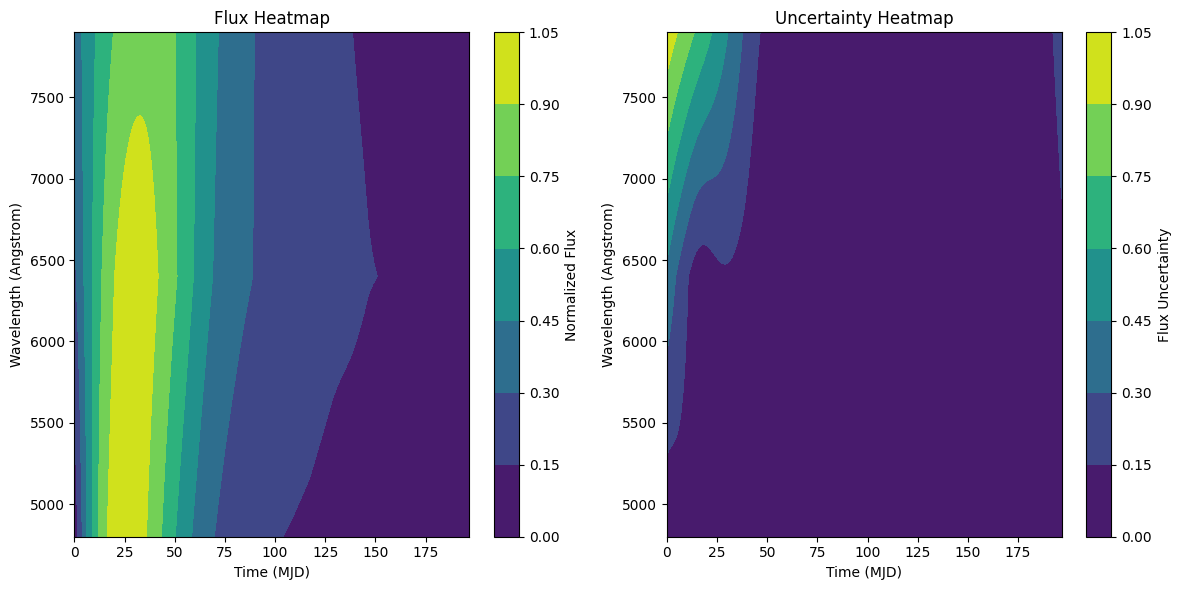

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mjd = data['mjd'].values
flux_ztfg = data['flux_ztfg'].values
flux_ztfi = data['flux_ztfi'].values
flux_ztfr = data['flux_ztfr'].values

flux_error_ztfg = data['flux_error_ztfg'].values
flux_error_ztfi = data['flux_error_ztfi'].values
flux_error_ztfr = data['flux_error_ztfr'].values

pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
}

unique_mjd = np.unique(mjd)
wavelengths = np.array([pb_wavelengths['ztfg'], pb_wavelengths['ztfr'], pb_wavelengths['ztfi']])

grid_time, grid_wavelength = np.meshgrid(unique_mjd, wavelengths)

grid_flux = np.vstack([flux_ztfg, flux_ztfr, flux_ztfi])
grid_flux_error = np.vstack([flux_error_ztfg, flux_error_ztfr, flux_error_ztfi])

grid_flux_normalized = grid_flux / np.nanmax(grid_flux)

grid_flux_error_norm = grid_flux_error / np.nanmax(grid_flux_error)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Flux Heatmap')
plt.contourf(grid_time, grid_wavelength, grid_flux_normalized, cmap='viridis')
plt.xlabel('Time (MJD)')
plt.ylabel('Wavelength (Angstrom)')
plt.colorbar(label='Normalized Flux')

plt.subplot(1, 2, 2)
plt.title('Uncertainty Heatmap')
plt.contourf(grid_time, grid_wavelength, grid_flux_error_norm, cmap='viridis')
plt.xlabel('Time (MJD)')
plt.ylabel('Wavelength (Angstrom)')
plt.colorbar(label='Flux Uncertainty')

plt.tight_layout()
plt.show()

plot_data.plot_gp(photo_ready, data)